In [1]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function for Formatting Dataset
def FormatDataset(dataset_src, dataset_dest, classes):
    # Making a Copy of Dataset
    new_cropped_dest = [os.path.join(dataset_dest, cls, 'CROPPED') for cls in classes];
    new_complete_dest = [os.path.join(dataset_dest, cls, 'COMPLETE') for cls in classes];
    cropped_src = [ dataset_src + "/im_" + cls + "/im_" + cls + "/CROPPED" for cls in classes ];
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes ];
    for (dest1, dest2) in zip(new_cropped_dest, new_complete_dest):
        os.makedirs(dest1);
        os.makedirs(dest2);
    # Formating Cropped Images
    for (src,new_dest) in zip(cropped_src, new_cropped_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (64, 64));
                img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);
    # Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
        for file in os.listdir(src):
            filename, file_ext = os.path.splitext(file);
            if file_ext == '.bmp':
                img_des = os.path.join(new_dest, filename + '.jpg');
                img = cv2.imread(os.path.join(src, file));
                img = cv2.resize(img, (256, 256));
                img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0);
                img = cv2.blur(img, (2, 2));
                cv2.imwrite(img_des ,img);

# Source Location for Dataset
src = 'F:/test1/input/cervical-cancer-largest-dataset-sipakmed';
# Destination Location for Dataset
dest = 'F:/test1/CervicalCancer';
# Image Classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Formatting Dataset
FormatDataset(src, dest, classes);

In [2]:
root_dir = "F:/test1/CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

def GetDatasetSize(path, classes, main = "CROPPED"):
    num_of_image = {}
    for cls in classes:
        # Counting the Number of Files in the Folder
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls, main)));
    return num_of_image;

print(GetDatasetSize(root_dir, classes, "COMPLETE"));

{'Dyskeratotic': 223, 'Koilocytotic': 238, 'Metaplastic': 271, 'Parabasal': 108, 'Superficial-Intermediate': 126}


### Split the Dataset such that we have
* 70% for Train Data
* 15% for Validation Data
* 15% for Testing Data

In [4]:
# Function for Creating Train / Validation / Test folders (One time use Only)

def TrainValTestSplit(root_dir, classes_dir, main = "CROPPED", val_ratio = 0.15, test_ratio = 0.15):
    for cls in classes_dir:
        # Creating Split Folders
        os.makedirs('train/' + cls)
        os.makedirs('val/' + cls)
        os.makedirs('test/' + cls)

        # Folder to copy images from
        src = os.path.join(root_dir, cls, main);

        # Spliting the Files in the Given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        # Printing the Split Details
        print(cls,':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, 'train/' + cls)

        for name in val_FileNames:
            shutil.copy(name, 'val/' + cls)

        for name in test_FileNames:
            shutil.copy(name, 'test/' + cls)
        print();
        

# Preforming Train / Validation / Test Split
root_dir = "./CervicalCancer"               # Dataset Root Folder
classes_dir = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]   # Classes
TrainValTestSplit(root_dir, classes_dir);

Dyskeratotic :
Total images:  813
Training:  569
Validation:  122
Testing:  122

Koilocytotic :
Total images:  825
Training:  577
Validation:  124
Testing:  124

Metaplastic :
Total images:  793
Training:  555
Validation:  119
Testing:  119

Parabasal :
Total images:  787
Training:  550
Validation:  118
Testing:  119

Superficial-Intermediate :
Total images:  831
Training:  581
Validation:  125
Testing:  125



### Building Model 


In [3]:
# Importing Keras for Image Classification
import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout,BatchNormalization
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [4]:

# CNN Model 

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization added
model.add(Dropout(rate=0.25))
model.add(Dense(units=5, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0

In [5]:
# CNN Model
model = Sequential()

# Convolutional Layer with input shape (64,64,3)
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(units=5, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Function to calculate number of computations for a layer
def compute_params_ops(layer):
    params = 0
    ops = 0
    try:
        params = layer.count_params()
        ops = params
        if layer.input_shape and len(layer.input_shape) == 4:
            ops *= layer.input_shape[1] * layer.input_shape[2]
    except Exception as e:
        print(f"An exception occurred for layer {layer}: {str(e)}")
    return params, ops

total_params, total_ops = 0, 0

for layer in model.layers:
    params, ops = compute_params_ops(layer)
    total_params += params
    total_ops += ops

print(f"Total number of parameters: {total_params}")
print(f"Total number of computations: {total_ops}")
model.summary()

Total number of parameters: 393957
Total number of computations: 51518725
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 batch_normalization_2 (Batc  (None, 62, 62, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                              

### Preparing data using data generator 

In [6]:
# Expand the size of dataset with new transformed images from the original dataset using ImageDataGenerator.
train_datagen = image.ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2 , rescale = 1./255 , horizontal_flip=True)
val_datagen = image.ImageDataGenerator(rescale = 1./255)
test_datagen = image.ImageDataGenerator(rescale = 1./255)

In [7]:
train_data = train_datagen.flow_from_directory(directory= "F:/test1/train", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 2832 images belonging to 5 classes.


In [8]:
train_data.class_indices

{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [9]:
val_data = val_datagen.flow_from_directory(directory= "F:/test1/val", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 608 images belonging to 5 classes.


In [10]:
test_data = test_datagen.flow_from_directory(directory= "F:/test1/test", target_size=(64, 64), batch_size=100, class_mode = 'categorical')

Found 609 images belonging to 5 classes.


In [11]:
# Adding Model check point Callback
mc = ModelCheckpoint(filepath="cervical_cancer_best_model1.hdf5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto');
call_back = [ mc ];

In [12]:
# Fitting the Model
cnn = model.fit(train_data, 
                  steps_per_epoch= 28, 
                  epochs= 32,
                  validation_data= val_data, 
                  validation_steps= 6,
                  callbacks = call_back )

Epoch 1/32
28/28 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.6805
Epoch 1: val_accuracy improved from -inf to 0.20667, saving model to cervical_cancer_best_model1.hdf5
28/28 [==============================] - 9s 273ms/step - loss: 0.8878 - accuracy: 0.6805 - val_loss: 1.5698 - val_accuracy: 0.2067
Epoch 2/32
28/28 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.7793
Epoch 2: val_accuracy did not improve from 0.20667
28/28 [==============================] - 6s 229ms/step - loss: 0.6017 - accuracy: 0.7793 - val_loss: 1.8037 - val_accuracy: 0.1967
Epoch 3/32
28/28 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.8034
Epoch 3: val_accuracy did not improve from 0.20667
28/28 [==============================] - 7s 233ms/step - loss: 0.5368 - accuracy: 0.8034 - val_loss: 2.4374 - val_accuracy: 0.1950
Epoch 4/32
28/28 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.8353
Epoch 4: val_accuracy did n

In [13]:
# Loading the Best Fit Model 
model = load_model("./cervical_cancer_best_model1.hdf5")

### Model Accuracy

In [14]:
# Checking the Accuracy of the Model 
accuracy = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of your model is = {accuracy*100} %")


The accuracy of your model is = 91.95402264595032 %


In [15]:
h =  cnn.history;
h.keys();

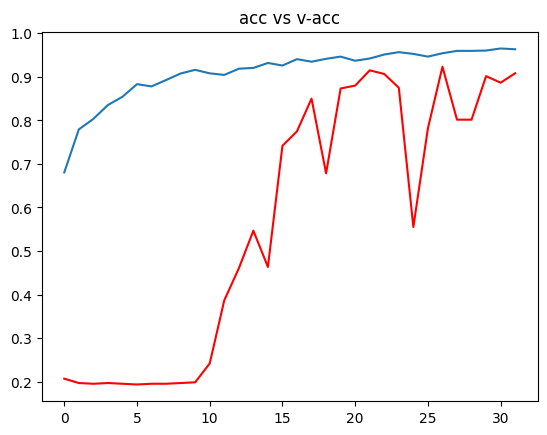

In [16]:
# Ploting Accuracy In Training Set & Validation Set

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

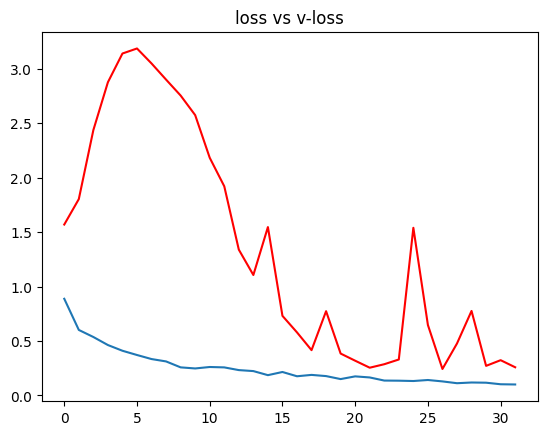

In [17]:
# Ploting Loss In Training Set & Validation Set

plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

7/7 [==============================] - 0s 47ms/step


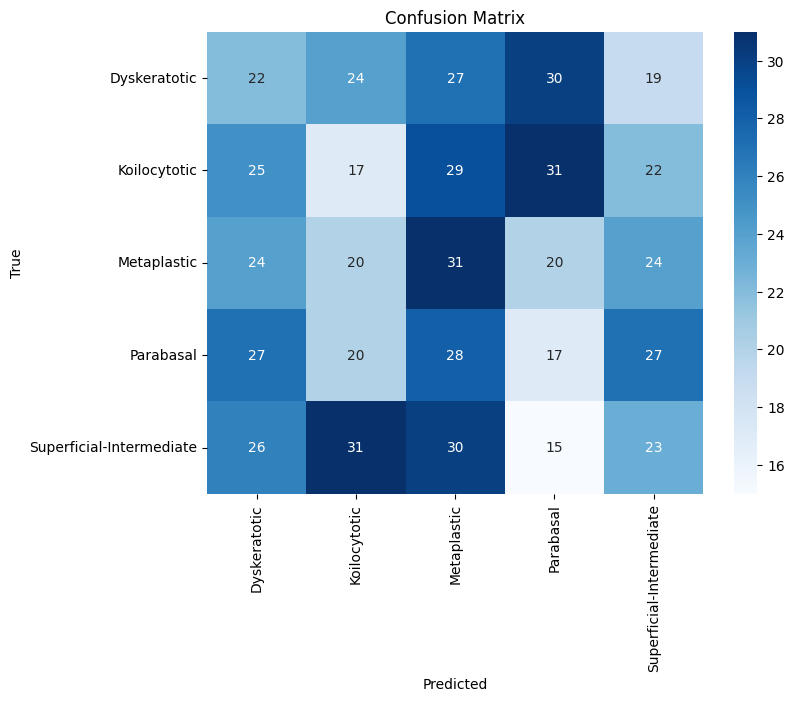

Accuracy: 18.06%
                          precision    recall  f1-score   support

            Dyskeratotic       0.18      0.18      0.18       122
            Koilocytotic       0.15      0.14      0.14       124
             Metaplastic       0.21      0.26      0.23       119
               Parabasal       0.15      0.14      0.15       119
Superficial-Intermediate       0.20      0.18      0.19       125

                accuracy                           0.18       609
               macro avg       0.18      0.18      0.18       609
            weighted avg       0.18      0.18      0.18       609



In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"];
# Generate predictions for the test dataset
y_pred = model.predict(test_data)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels from the test dataset generator
y_true = test_data.classes

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate classification report to calculate precision, recall, and F1-score
class_report = classification_report(y_true, y_pred_classes, target_names=classes)
print(class_report)